# Project Name and Description

## Contents
1. Frame the problem  and look at the big picture
2. Get the data
3. Explore and visualize the data to gain insights
4. Prepare the data to better expose the underlying patterns to machine learning algorithm
5. Explore many modesl; Select a model and train it
6. Fine-tune the model
7. Present your solution
8. Deploy, monitor and maintain your system

## 1. Frame the problem
todo


In [1]:
# Imports
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


/tmp/ipykernel_234277/348397823.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Settings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)


## 2. Get the data

In [3]:

df = pd.read_csv('data/german.data', delimiter=' ', header=None)
df.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2
999,A12,45,A34,A41,4576,A62,A71,3,A93,A101,...,A123,27,A143,A152,1,A173,1,A191,A201,1


In [4]:
# View the attribute names from the info document
path = ('data/german.doc')

with open(path, mode='r') as file:
    text = file.read()
    
pattern = r"Attr?ibute (?P<attr>\d{1,2}):.+?\n\s+(?P<name>.+?)\n"

print("Feature number and name:")
for m in re.finditer(pattern, text):
    print("{attr}: {name}".format(**m.groupdict()))

Feature number and name:
1: Status of existing checking account
2: Duration in month
3: Credit history
4: Purpose
5: Credit amount
6: Savings account/bonds
7: Present employment since
8: Installment rate in percentage of disposable income
9: Personal status and sex
10: Other debtors / guarantors
11: Present residence since
12: Property
13: Age in years
14: Other installment plans 
15: Housing
16: Number of existing credits at this bank
17: Job
18: Number of people being liable to provide maintenance for
19: Telephone
20: foreign worker


In [5]:
col_names = [
    "status",    #1 (balance)
    "duration",  #2 (tenure)
    "history",   #3
    "purpose",   #4 (purpose of the loan)
    "amount",    #5 (credit amount requested)
    "savings",   #6 (savings or bonds)
    "employment",#7 (curent employment duration)
    "income",     #8 (Installment rate in percentage of disposable income)
    "personal",  #9 (Personal status and sex)
    "guarantor", #10
    "residence", #11
    "property",  #12
    "age",       #13
    "installments", #14 (Other installment plans)
    "housing",    #15
    "credits",      #16 (Number of existing credits at this bank)
    "job",        #17
    "maintenance", #18
    "telephone",  #19
    "foreign",    #20
    "label"
            ]
df.columns = col_names

df.head()

,status,duration,history,purpose,amount,savings,employment,income,personal,guarantor,...,property,age,installments,housing,credits,job,maintenance,telephone,foreign,label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Rename the categories

In [6]:
# Make a mapping for categories
mapping = {
0: {
    'A11' : "overdrawn",
    'A12' : "up to 200 DM",
    'A13' : "monthly salary",
    'A14' : "no account"
    },

2: {
    'A30' : "no loans",
    'A31' : "duly paid",
    'A32' : "so far so good",
    'A33' : "delay",
    'A34' : "critical",
},

3: {
    'A40' : "car",
    'A41' : "used car",
    'A42' : "furniture",
    'A43' : "television",
    'A44' : "appliances",
    'A45' : "repairs",
    'A46' : "education",
    'A47' : "vacation",
    'A48' : "retraining",
    'A49' : "business",
    'A410': "other",
},

5: {
    'A61' : "[0, 1000) DM",
    'A62' : "[100, 500) DM",
    'A63' : "[500, 1000) DM",
    'A64' : "[1000, ∞) DM",
    'A65' : "no savings",
}, 

6: {
    'A71' : "unemployed",
    'A72' : "[0, 1)",
    'A73' : "[1, 4)",
    'A74' : "[4, 7)",
    'A75' : "[7, ∞)",
},

8: {
    'A91' : "male divorced/separated",
    'A92' : "female divorced/separated/married",
    'A93' : "male single",
    'A94' : "male married/widowed",
    'A95' : "female single",
},

9: {
    'A101' : "none",
    'A102' : "co-applicant",
    'A103' : "guarantor",
},

11: {
    'A121' : "real estate",
    'A122' : "building",
    'A123' : "car",
    'A124' : "unknown",
},

13: {
    'A141' : "bank",
    'A142' : "stores",
    'A143' : "none",
},

14: {
    'A151' : "rent",
    'A152' : "own",
    'A153' : "for free",
},

16: {
    'A171' : "unemployed/unskilled non-resident",
    'A172' : "unskilled resident",
    'A173' : "skilled",
    'A174' : "white color",
},

18: {
    'A191' : "none",
    'A192' : "yes",
},

19: {
    'A201' : True,
    'A202' : False,
},

20: {
    1: 0,  # good
    2: 1,  # bad
}}


In [7]:
# Rename the categories
for i, d in mapping.items():
    df.iloc[:, i] = df.iloc[:, i].map(d)

df.head(10)

,status,duration,history,purpose,amount,savings,employment,income,personal,guarantor,...,property,age,installments,housing,credits,job,maintenance,telephone,foreign,label
0,overdrawn,6,critical,television,1169,no savings,"[7, ∞)",4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,True,0
1,up to 200 DM,48,so far so good,television,5951,"[0, 1000) DM","[1, 4)",2,female divorced/separated/married,none,...,real estate,22,none,own,1,skilled,1,none,True,1
2,no account,12,critical,education,2096,"[0, 1000) DM","[4, 7)",2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,True,0
3,overdrawn,42,so far so good,furniture,7882,"[0, 1000) DM","[4, 7)",2,male single,guarantor,...,building,45,none,for free,1,skilled,2,none,True,0
4,overdrawn,24,delay,car,4870,"[0, 1000) DM","[1, 4)",3,male single,none,...,unknown,53,none,for free,2,skilled,2,none,True,1
5,no account,36,so far so good,education,9055,no savings,"[1, 4)",2,male single,none,...,unknown,35,none,for free,1,unskilled resident,2,yes,True,0
6,no account,24,so far so good,furniture,2835,"[500, 1000) DM","[7, ∞)",3,male single,none,...,building,53,none,own,1,skilled,1,none,True,0
7,up to 200 DM,36,so far so good,used car,6948,"[0, 1000) DM","[1, 4)",2,male single,none,...,car,35,none,rent,1,white color,1,yes,True,0
8,no account,12,so far so good,television,3059,"[1000, ∞) DM","[4, 7)",2,male divorced/separated,none,...,real estate,61,none,own,1,unskilled resident,1,none,True,0
9,up to 200 DM,30,critical,car,5234,"[0, 1000) DM",unemployed,4,male married/widowed,none,...,car,28,none,own,2,white color,1,none,True,1


In [8]:
# Rearrange the columns: num, cat, label
df = pd.concat([df.select_dtypes(np.number), df.select_dtypes(object)], axis=1)
df['label'] = df.pop('label')
df.head()

,duration,amount,income,residence,age,credits,maintenance,status,history,purpose,...,employment,personal,guarantor,property,installments,housing,job,telephone,foreign,label
0,6,1169,4,4,67,2,1,overdrawn,critical,television,...,"[7, ∞)",male single,none,real estate,none,own,skilled,yes,True,0
1,48,5951,2,2,22,1,1,up to 200 DM,so far so good,television,...,"[1, 4)",female divorced/separated/married,none,real estate,none,own,skilled,none,True,1
2,12,2096,2,3,49,1,2,no account,critical,education,...,"[4, 7)",male single,none,real estate,none,own,unskilled resident,none,True,0
3,42,7882,2,4,45,1,2,overdrawn,so far so good,furniture,...,"[4, 7)",male single,guarantor,building,none,for free,skilled,none,True,0
4,24,4870,3,4,53,2,2,overdrawn,delay,car,...,"[1, 4)",male single,none,unknown,none,for free,skilled,none,True,1


In [9]:
df.label.sum() / len(df)

0.3

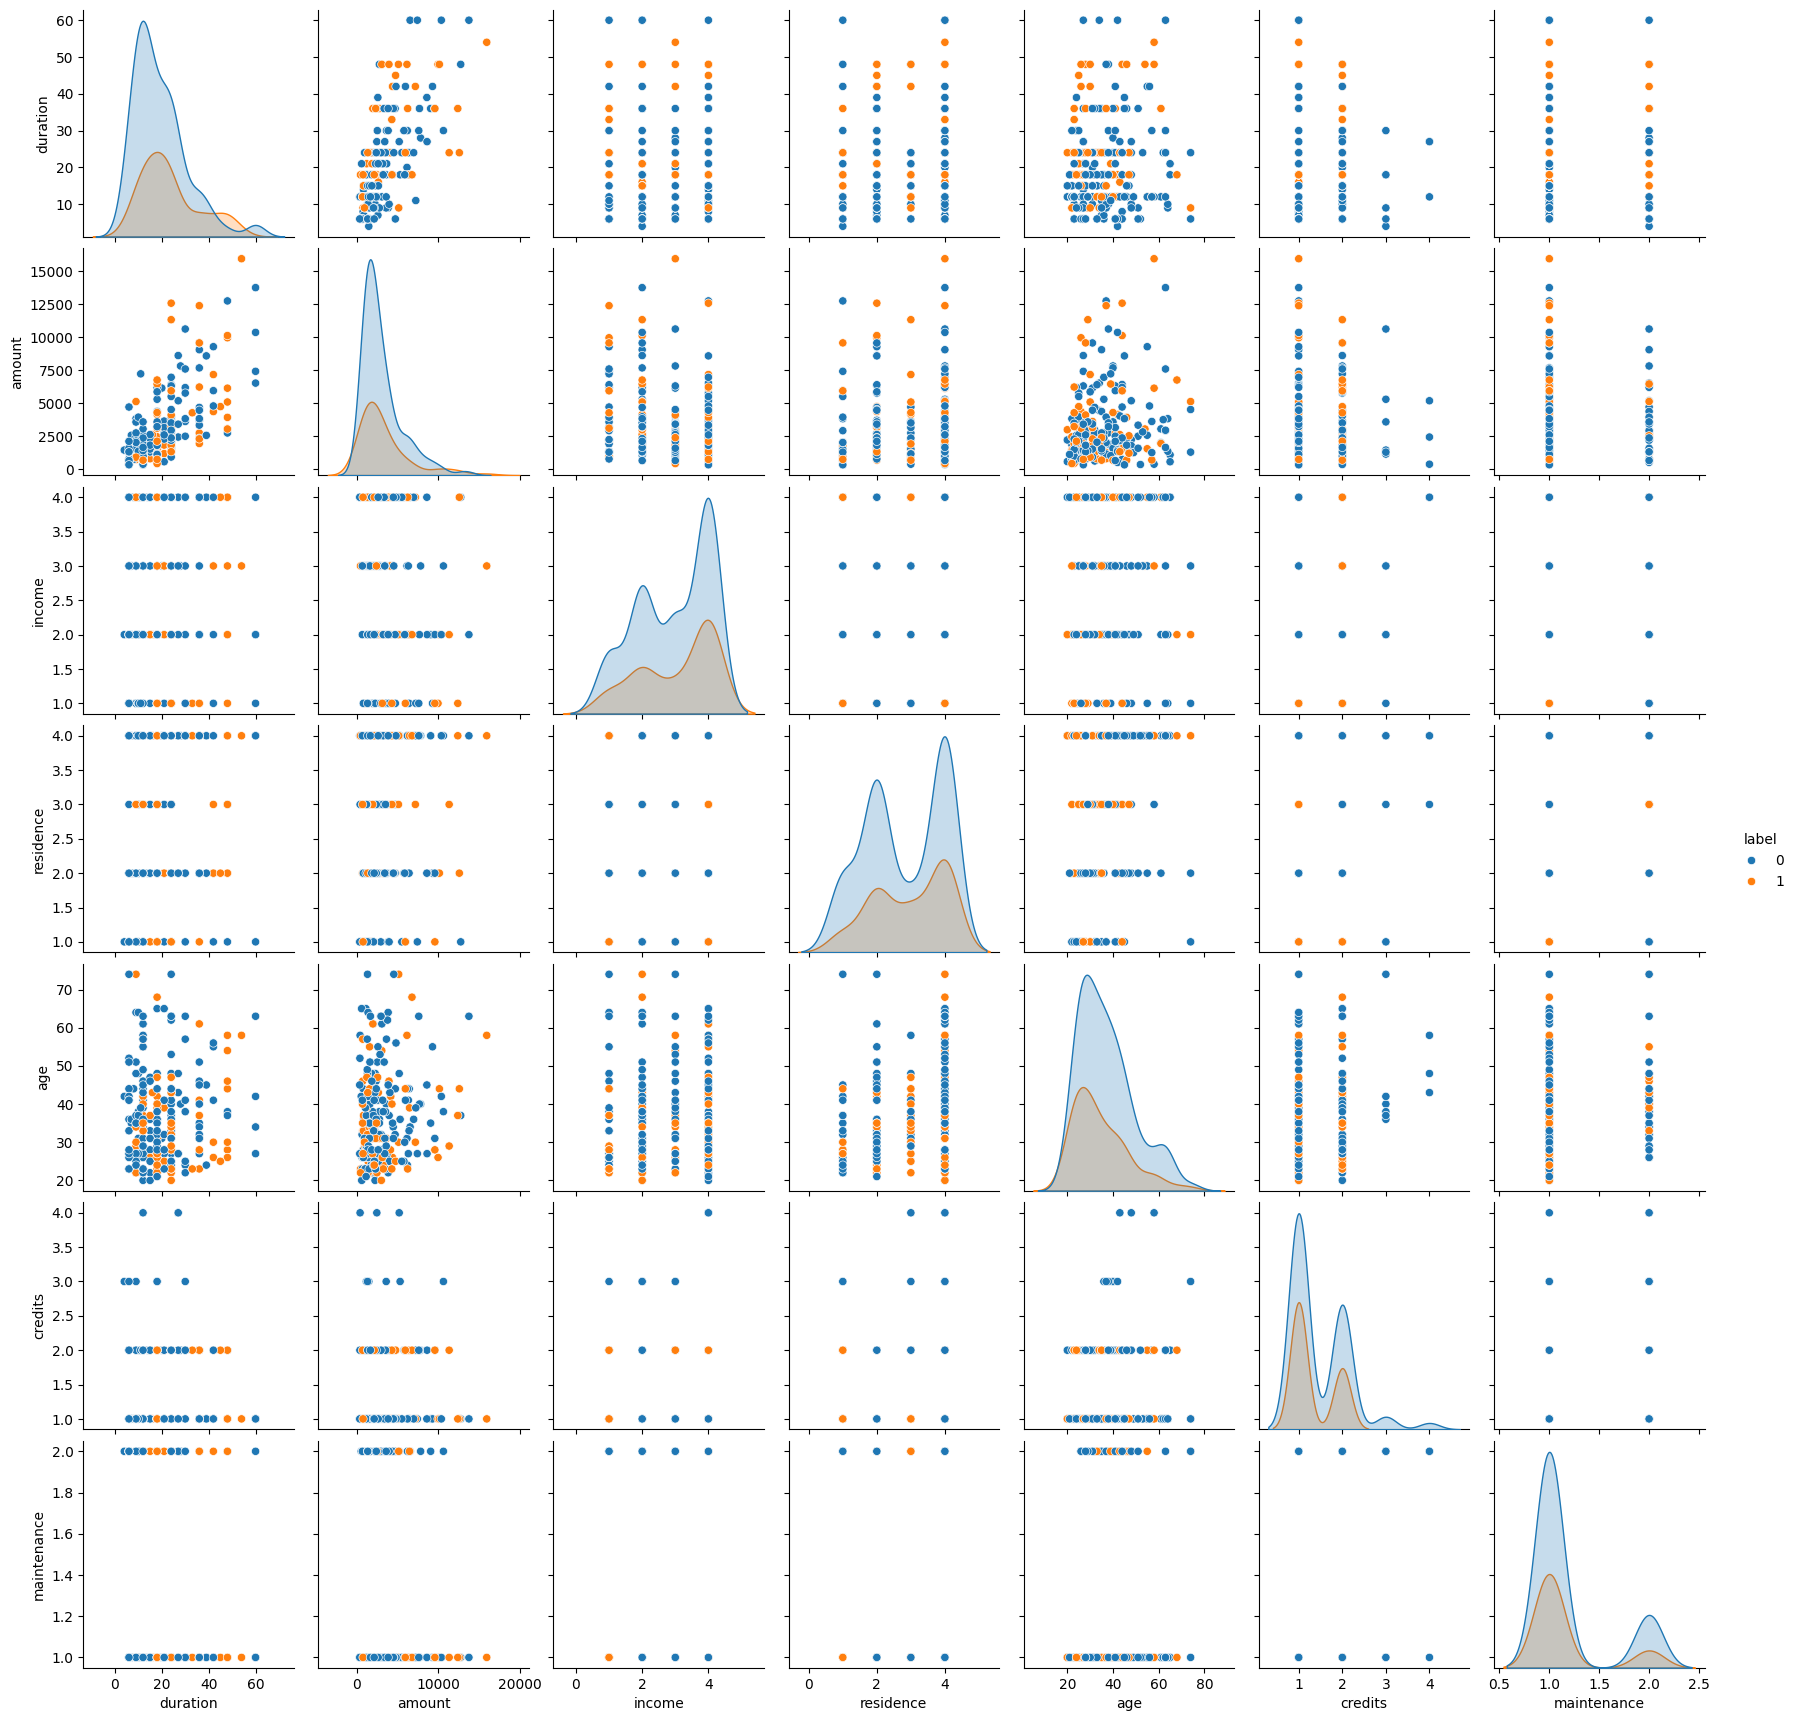

In [10]:
sns.pairplot(df.select_dtypes(np.number).sample(250), hue='label');